Run 370321: original LS 49 -> 53, applying LS offset 0
Run 370332: original LS 1 -> 1987, applying LS offset 53
Saved fill9045_rates.pdf, fill9045_rates.jpg


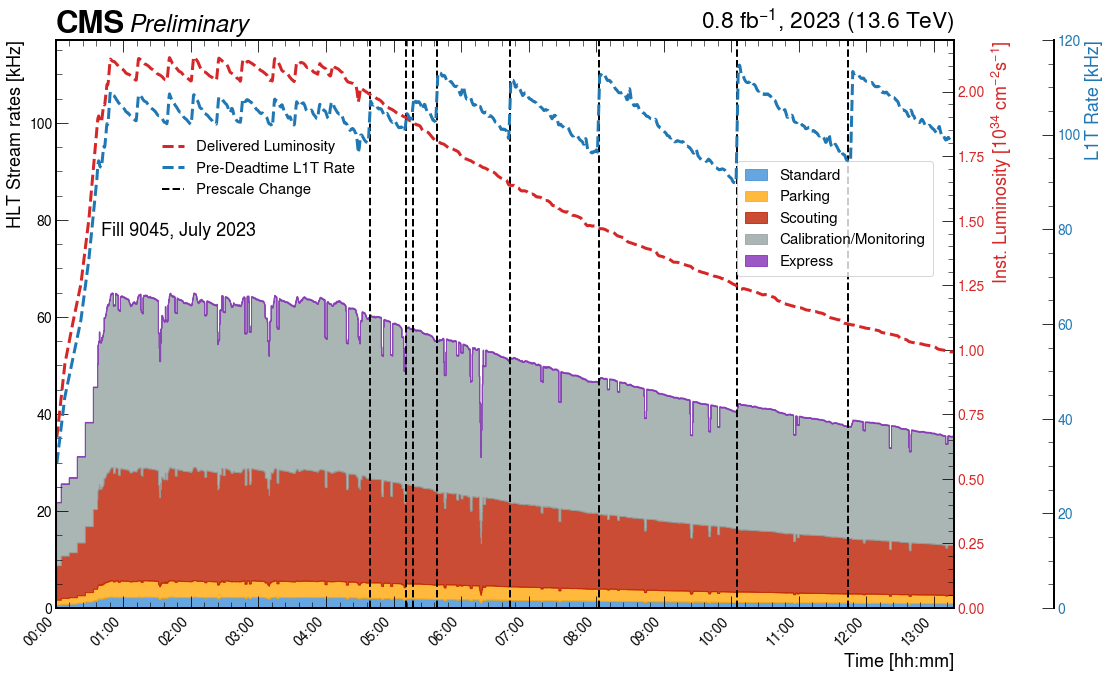

In [5]:
#!/usr/bin/env python3
import json
import numpy as np
import matplotlib.pyplot as plt
import mplhep as hep
from datetime import datetime
from matplotlib.ticker import MultipleLocator, FuncFormatter

# -----------------------------------------------------------------------------
# Configuration
# -----------------------------------------------------------------------------
JSON_PATH = "fill_9045.json"
RUNS_TO_PROCESS = {
    "370321": lambda ls: ls >= 49,
    "370332": lambda ls: ls >= 1,
}
SMOOTH_WINDOW = 5
OUTPUT_PDF = "fill9045_rates.pdf"
OUTPUT_JPG = "fill9045_rates.jpg"
OUTPUT_PNG = "fill9045_rates.png"

YEAR = 2023
LUMI_LABEL = 0.8
CMS_ENERGY = 13.6

PRESCALE_LSES = [680, 763, 779, 834, 1001, 1204, 1521, 1775]
IGNORE_LSES = []  # LS to ignore

# -----------------------------------------------------------------------------
# Helpers
# -----------------------------------------------------------------------------
def moving_average(data, window_size=SMOOTH_WINDOW):
    arr = np.array(data, dtype=float)
    if len(arr) < window_size:
        return np.array([])
    csum = np.cumsum(np.insert(arr, 0, 0.0))
    return (csum[window_size:] - csum[:-window_size]) / float(window_size)

def classify_stream(name):
    if name.startswith("Physics"):   return "Standard"
    if name.startswith("Parking"):   return "Parking"
    if name.startswith("Scouting"):  return "Scouting"
    if name.startswith("Express"):   return "Express"
    if name.startswith(("ALCA", "Calibration")) or (name.startswith("DQM") and name != "DQMHistograms") or name.startswith("NanoDST"):
        return "Calibration/Monitoring"
    return None

def hhmm_fmt(x, pos=None):
    h = int(x)
    m = int(round((x - h) * 60))
    return f"{h:02d}:{m:02d}"

# -----------------------------------------------------------------------------
# Load JSON and merge runs
# -----------------------------------------------------------------------------
with open(JSON_PATH) as fp:
    all_data = json.load(fp)

corrected_run_data = {}
ls_offset = 0

for run, ls_filter in RUNS_TO_PROCESS.items():
    run_data = all_data.get(run, {})
    if not run_data:
        print(f"Run {run} not found, skipping.")
        continue

    all_ls = [e["LS"] for entries in run_data.values() for e in entries if ls_filter(e["LS"])]
    if not all_ls:
        print(f"No valid LS found for run {run}, skipping.")
        continue

    last_ls = max(all_ls)
    print(f"Run {run}: original LS {min(all_ls)} -> {last_ls}, applying LS offset {ls_offset}")

    for stream, entries in run_data.items():
        corrected_run_data.setdefault(stream, [])
        for e in entries:
            if not ls_filter(e["LS"]):
                continue
            e = e.copy()
            e["LS"] += ls_offset
            corrected_run_data[stream].append(e)

    ls_offset += last_ls

run_data = corrected_run_data

# -----------------------------------------------------------------------------
# Find t0
# -----------------------------------------------------------------------------
all_times = [
    datetime.strptime(e["start_time"], "%Y-%m-%dT%H:%M:%SZ")
    for entries in run_data.values() for e in entries
    if e["LS"] > 0 and e["LS"] not in IGNORE_LSES
]
if not all_times:
    raise RuntimeError("No good LS found after cut!")
t0 = min(all_times)

# -----------------------------------------------------------------------------
# Aggregate per-lumisection
# -----------------------------------------------------------------------------
cats = ["Standard", "Parking", "Scouting", "Calibration/Monitoring", "Express"]
summed = {c: {} for c in cats}
deliv = {}
l1raw = {}
pre_deadtime = {}
times_ls = {}

for stream, entries in run_data.items():
    cat = classify_stream(stream)
    if not cat:
        continue

    for e in entries:
        ls = e["LS"]
        if ls <= 0 or ls in IGNORE_LSES:
            continue

        if ls not in times_ls:
            times_ls[ls] = datetime.strptime(e["start_time"], "%Y-%m-%dT%H:%M:%SZ")

        summed[cat].setdefault(ls, 0.0)
        summed[cat][ls] += e["rate"] / 1000.0  # Hz → kHz

        deliv.setdefault(ls, e["delivered_lumi_per_lumisection"])

        if ls not in l1raw and "hlt_rate_Status_OnGPU" in e:
            l1raw[ls] = e["hlt_rate_Status_OnGPU"] / 1000.0

        if "deadtime" in e and ls in l1raw:
            dt = e["deadtime"]
            pre_deadtime[ls] = l1raw[ls] / (1 - dt) if dt < 1 else l1raw[ls]

# -----------------------------------------------------------------------------
# Build sorted arrays & smooth
# -----------------------------------------------------------------------------
ls_sorted = sorted(times_ls)

rates = {c: [summed[c].get(ls, 0.0) for ls in ls_sorted] for c in cats}
lumi = [deliv[ls] for ls in ls_sorted]
l1rate = [pre_deadtime.get(ls, 0.0) for ls in ls_sorted]

#print(l1rate)

times_arr = [(times_ls[ls] - t0).total_seconds() / 3600.0 for ls in ls_sorted]

rates_sm = {c: moving_average(rates[c]) for c in cats}
lumi_sm = moving_average(lumi)
l1_sm = moving_average(l1rate)
time_sm = moving_average(times_arr)

L = min(*(len(rates_sm[c]) for c in cats), len(lumi_sm), len(l1_sm), len(time_sm))
for c in cats:
    rates_sm[c] = rates_sm[c][:L]
lumi_sm = lumi_sm[:L]
l1_sm = l1_sm[:L]
time_sm = time_sm[:L]

# -----------------------------------------------------------------------------
# Plot
# -----------------------------------------------------------------------------
plt.style.use(hep.style.CMS)
fig, ax1 = plt.subplots(figsize=(16, 10))
fig.subplots_adjust(left=0.30, right=0.78, top=0.88)

area_handles, area_labels = [], []
cum = np.zeros(L)
colors = ["#3f90da", "#ffa90e", "#bd1f01", "#94a4a2", "#832db6"]
for cat, col in zip(cats, colors):
    h = ax1.fill_between(time_sm, cum, cum + rates_sm[cat], step="mid", alpha=0.8, color=col)
    area_handles.append(h)
    area_labels.append(cat)
    cum += rates_sm[cat]

# Prescale transitions
prescale_handle = None
for ls in PRESCALE_LSES:
    if ls in ls_sorted:
        idx = ls_sorted.index(ls)
        x = time_sm[max(0, idx - (SMOOTH_WINDOW // 2))]
        if prescale_handle is None:
            prescale_handle = ax1.axvline(x, color="black", linestyle="--", linewidth=2, label="Prescale Change")
        else:
            ax1.axvline(x, color="black", linestyle="--", linewidth=2)

ax1.set_xlabel("Time [hh:mm]", fontsize=18)
ax1.set_ylabel("HLT Stream rates [kHz]", fontsize=18)
ax1.set_xlim(0, time_sm[-1]*0.99)
ax1.set_ylim(0, cum.max() * 1.8)
ax1.tick_params(labelsize=14)
ax1.set_xticks(np.arange(0, np.floor(time_sm[-1]) + 1, 1.0))
ax1.xaxis.set_major_formatter(FuncFormatter(hhmm_fmt))
plt.setp(ax1.get_xticklabels(), rotation=45, ha="right")

hep.cms.label(data=True, year=YEAR, lumi=LUMI_LABEL,
              loc=0, ax=ax1, com=CMS_ENERGY, label="Preliminary", fontsize=24)

ax1.text(0.05, 0.68, f"Fill 9045, July 2023", transform=ax1.transAxes, fontsize=18, verticalalignment="top")

# Delivered lumi
ax2 = ax1.twinx()
lum_handle, = ax2.plot(time_sm, lumi_sm * 100 / 23.31, color="tab:red", linestyle="--", linewidth=3, label="Delivered Luminosity")
ax2.set_ylabel("Inst. Luminosity [$10^{34}$ cm$^{-2}$s$^{-1}$]", color="tab:red", fontsize=18)
ax2.tick_params(labelcolor="tab:red", labelsize=14)
ax2.set_ylim(0, 2.2)

# Pre-deadtime L1
ax3 = ax1.twinx()
ax3.spines["right"].set_position(("outward", 100))
l1_handle, = ax3.plot(time_sm, l1_sm, color="tab:blue", linestyle="--", linewidth=3, label="Pre-Deadtime L1T Rate")
ax3.set_ylabel("L1T Rate [kHz]", color="tab:blue", fontsize=18)
ax3.tick_params(labelcolor="tab:blue", labelsize=14)
ax3.set_ylim(0, 120)

# Legends
leg1 = ax1.legend(area_handles, area_labels, loc="upper left", bbox_to_anchor=(0.75, 0.8), frameon=True, framealpha=0.8, fontsize=15)
ax1.add_artist(leg1)

extra_labels = [lum_handle, l1_handle]
extra_names = ["Delivered Luminosity", "Pre-Deadtime L1T Rate"]
if prescale_handle:
    extra_labels.append(prescale_handle)
    extra_names.append("Prescale Change")

leg2 = ax1.legend(extra_labels, extra_names, loc="upper right", bbox_to_anchor=(0.35, 0.85), fontsize=15)

plt.tight_layout()
fig.savefig(OUTPUT_PDF, dpi=300)
fig.savefig(OUTPUT_JPG, dpi=300)
fig.savefig(OUTPUT_PNG, dpi=300)
print(f"Saved {OUTPUT_PDF}, {OUTPUT_JPG}")

Run 370321: original LS 49 -> 53, applying LS offset 0
Run 370332: original LS 1 -> 1987, applying LS offset 53
Saved fill9045_bandwidth.pdf, fill9045_bandwidth.jpg


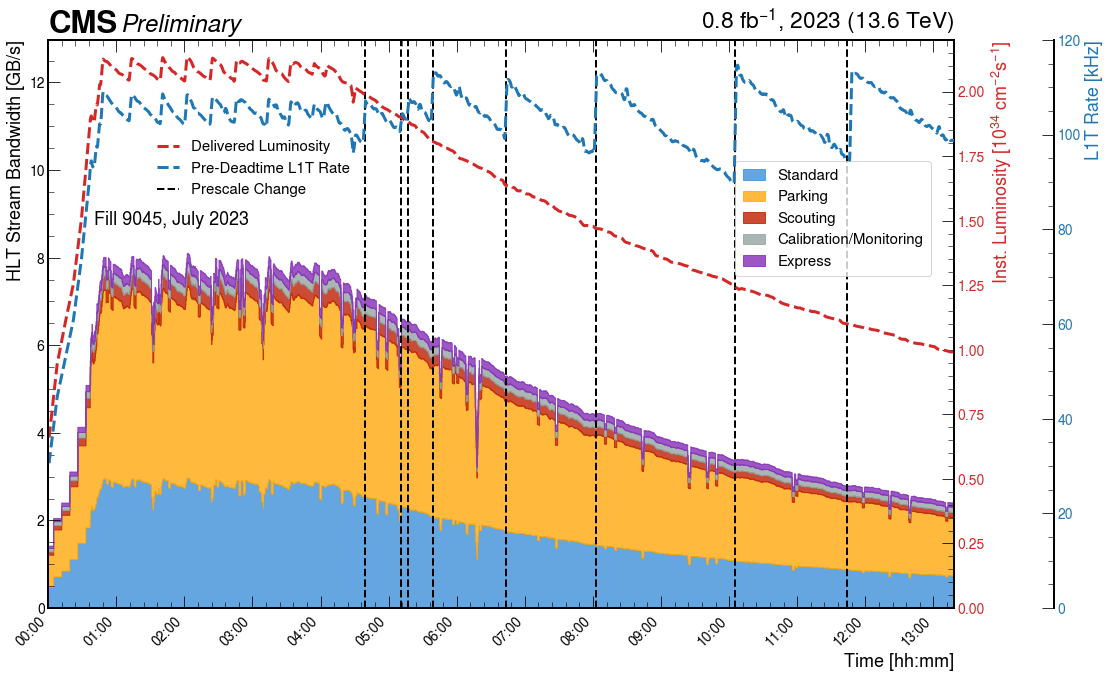

In [2]:
#!/usr/bin/env python3
import json
import numpy as np
import matplotlib.pyplot as plt
import mplhep as hep
from datetime import datetime
from matplotlib.ticker import MultipleLocator, FuncFormatter

# -----------------------------------------------------------------------------
# Configuration
# -----------------------------------------------------------------------------
JSON_PATH = "fill_9045.json"
RUNS_TO_PROCESS = {
    "370321": lambda ls: ls >= 49,
    "370332": lambda ls: ls >= 1,
}
SMOOTH_WINDOW = 5
OUTPUT_PDF = "fill9045_bandwidth.pdf"
OUTPUT_JPG = "fill9045_bandwidth.jpg"
OUTPUT_PNG = "fill9045_bandwidth.png"
YEAR = 2023
LUMI_LABEL = 0.8
CMS_ENERGY = 13.6

PRESCALE_LSES = [680, 763, 779, 834, 1001, 1204, 1521, 1775]
IGNORE_LSES = []

# -----------------------------------------------------------------------------
# Helpers
# -----------------------------------------------------------------------------
def moving_average(data, window_size=SMOOTH_WINDOW):
    arr = np.array(data, dtype=float)
    if len(arr) < window_size:
        return np.array([])
    csum = np.cumsum(np.insert(arr, 0, 0.0))
    return (csum[window_size:] - csum[:-window_size]) / float(window_size)

def classify_stream(name):
    if name.startswith("Physics"):   return "Standard"
    if name.startswith("Parking"):   return "Parking"
    if name.startswith("Scouting"):  return "Scouting"
    if name.startswith("Express"):   return "Express"
    if name.startswith(("ALCA", "Calibration")) or (name.startswith("DQM") and name != "DQMHistograms") or name.startswith("NanoDST"):
        return "Calibration/Monitoring"
    return None

def hhmm_fmt(x, pos=None):
    h = int(x)
    m = int(round((x - h) * 60))
    return f"{h:02d}:{m:02d}"

# -----------------------------------------------------------------------------
# Load JSON and merge runs
# -----------------------------------------------------------------------------
with open(JSON_PATH) as fp:
    all_data = json.load(fp)

corrected_run_data = {}
ls_offset = 0

for run, ls_filter in RUNS_TO_PROCESS.items():
    run_data = all_data.get(run, {})
    if not run_data:
        print(f"Run {run} not found, skipping.")
        continue

    all_ls = [e["LS"] for entries in run_data.values() for e in entries if ls_filter(e["LS"])]
    if not all_ls:
        print(f"No valid LS found for run {run}, skipping.")
        continue

    last_ls = max(all_ls)
    print(f"Run {run}: original LS {min(all_ls)} -> {last_ls}, applying LS offset {ls_offset}")

    for stream, entries in run_data.items():
        corrected_run_data.setdefault(stream, [])
        for e in entries:
            if not ls_filter(e["LS"]):
                continue
            e = e.copy()
            e["LS"] += ls_offset
            corrected_run_data[stream].append(e)

    ls_offset += last_ls

run_data = corrected_run_data

# -----------------------------------------------------------------------------
# Find t0
# -----------------------------------------------------------------------------
all_times = [
    datetime.strptime(e["start_time"], "%Y-%m-%dT%H:%M:%SZ")
    for entries in run_data.values() for e in entries
    if e["LS"] > 0 and e["LS"] not in IGNORE_LSES
]
if not all_times:
    raise RuntimeError("No good LS found after cut!")
t0 = min(all_times)

# -----------------------------------------------------------------------------
# Aggregate per-lumisection
# -----------------------------------------------------------------------------
cats = ["Standard", "Parking", "Scouting", "Calibration/Monitoring", "Express"]
summed = {c: {} for c in cats}
deliv = {}
l1raw = {}
pre_deadtime = {}
times_ls = {}

for stream, entries in run_data.items():
    cat = classify_stream(stream)
    if not cat:
        continue

    for e in entries:
        ls = e["LS"]
        if ls <= 0 or ls in IGNORE_LSES:
            continue

        if ls not in times_ls:
            times_ls[ls] = datetime.strptime(e["start_time"], "%Y-%m-%dT%H:%M:%SZ")

        # --- bandwidth instead of rate ---
        summed[cat].setdefault(ls, 0.0)
        summed[cat][ls] += e.get("bandwidth", 0.0) / 1e9  # Convert bytes/sec to GB/sec

        deliv.setdefault(ls, e["delivered_lumi_per_lumisection"])

        if ls not in l1raw and "hlt_rate_Status_OnGPU" in e:
            l1raw[ls] = e["hlt_rate_Status_OnGPU"] / 1000.0

        if "deadtime" in e and ls in l1raw:
            dt = e["deadtime"]
            pre_deadtime[ls] = l1raw[ls] / (1 - dt) if dt < 1 else l1raw[ls]

# -----------------------------------------------------------------------------
# Build sorted arrays & smooth
# -----------------------------------------------------------------------------
ls_sorted = sorted(times_ls)

rates = {c: [summed[c].get(ls, 0.0) for ls in ls_sorted] for c in cats}
lumi = [deliv[ls] for ls in ls_sorted]
l1rate = [pre_deadtime.get(ls, 0.0) for ls in ls_sorted]

times_arr = [(times_ls[ls] - t0).total_seconds() / 3600.0 for ls in ls_sorted]

rates_sm = {c: moving_average(rates[c]) for c in cats}
lumi_sm = moving_average(lumi)
l1_sm = moving_average(l1rate)
time_sm = moving_average(times_arr)

L = min(*(len(rates_sm[c]) for c in cats), len(lumi_sm), len(l1_sm), len(time_sm))
for c in cats:
    rates_sm[c] = rates_sm[c][:L]
lumi_sm = lumi_sm[:L]
l1_sm = l1_sm[:L]
time_sm = time_sm[:L]

# -----------------------------------------------------------------------------
# Plot
# -----------------------------------------------------------------------------
plt.style.use(hep.style.CMS)
fig, ax1 = plt.subplots(figsize=(16, 10))
fig.subplots_adjust(left=0.30, right=0.78, top=0.88)

area_handles, area_labels = [], []
cum = np.zeros(L)
colors = ["#3f90da", "#ffa90e", "#bd1f01", "#94a4a2", "#832db6"]
for cat, col in zip(cats, colors):
    h = ax1.fill_between(time_sm, cum, cum + rates_sm[cat], step="mid", alpha=0.8, color=col)
    area_handles.append(h)
    area_labels.append(cat)
    cum += rates_sm[cat]

# Prescale transitions
prescale_handle = None
for ls in PRESCALE_LSES:
    if ls in ls_sorted:
        idx = ls_sorted.index(ls)
        x = time_sm[max(0, idx - (SMOOTH_WINDOW // 2))]
        if prescale_handle is None:
            prescale_handle = ax1.axvline(x, color="black", linestyle="--", linewidth=2, label="Prescale Change")
        else:
            ax1.axvline(x, color="black", linestyle="--", linewidth=2)

ax1.set_xlabel("Time [hh:mm]", fontsize=18)
ax1.set_ylabel("HLT Stream Bandwidth [GB/s]", fontsize=18)
ax1.set_xlim(0, time_sm[-1]*0.99)
ax1.set_ylim(0, cum.max() * 1.6)
ax1.tick_params(labelsize=14)
ax1.set_xticks(np.arange(0, np.floor(time_sm[-1]) + 1, 1.0))
ax1.xaxis.set_major_formatter(FuncFormatter(hhmm_fmt))
plt.setp(ax1.get_xticklabels(), rotation=45, ha="right")

hep.cms.label(data=True, year=YEAR, lumi=LUMI_LABEL,
              loc=0, ax=ax1, com=CMS_ENERGY, label="Preliminary", fontsize=24)

ax1.text(0.05, 0.7, f"Fill 9045, July 2023", transform=ax1.transAxes, fontsize=18, verticalalignment="top")

# Delivered lumi
ax2 = ax1.twinx()
lum_handle, = ax2.plot(time_sm, lumi_sm * 100 / 23.31, color="tab:red", linestyle="--", linewidth=3, label="Delivered Luminosity")
ax2.set_ylabel("Inst. Luminosity [$10^{34}$ cm$^{-2}$s$^{-1}$]", color="tab:red", fontsize=18)
ax2.tick_params(labelcolor="tab:red", labelsize=14)
ax2.set_ylim(0, 2.2)

# Pre-deadtime L1
ax3 = ax1.twinx()
ax3.spines["right"].set_position(("outward", 100))
l1_handle, = ax3.plot(time_sm, l1_sm, color="tab:blue", linestyle="--", linewidth=3, label="Pre-Deadtime L1T Rate")
ax3.set_ylabel("L1T Rate [kHz]", color="tab:blue", fontsize=18)
ax3.tick_params(labelcolor="tab:blue", labelsize=14)
ax3.set_ylim(0, 120)

# Legends
leg1 = ax1.legend(area_handles, area_labels, loc="upper left", bbox_to_anchor=(0.75, 0.8), frameon=True, framealpha=0.8, fontsize=15)
ax1.add_artist(leg1)

extra_labels = [lum_handle, l1_handle]
extra_names = ["Delivered Luminosity", "Pre-Deadtime L1T Rate"]
if prescale_handle:
    extra_labels.append(prescale_handle)
    extra_names.append("Prescale Change")

leg2 = ax1.legend(extra_labels, extra_names, loc="upper right", bbox_to_anchor=(0.35, 0.85), fontsize=15)

plt.tight_layout()
fig.savefig(OUTPUT_PDF, dpi=1200)
fig.savefig(OUTPUT_JPG, dpi=1200)
fig.savefig(OUTPUT_PNG, dpi=1200)
print(f"Saved {OUTPUT_PDF}, {OUTPUT_JPG}")


Saved fill9045_physics_rates_grouped.pdf, fill9045_physics_rates_grouped.jpg


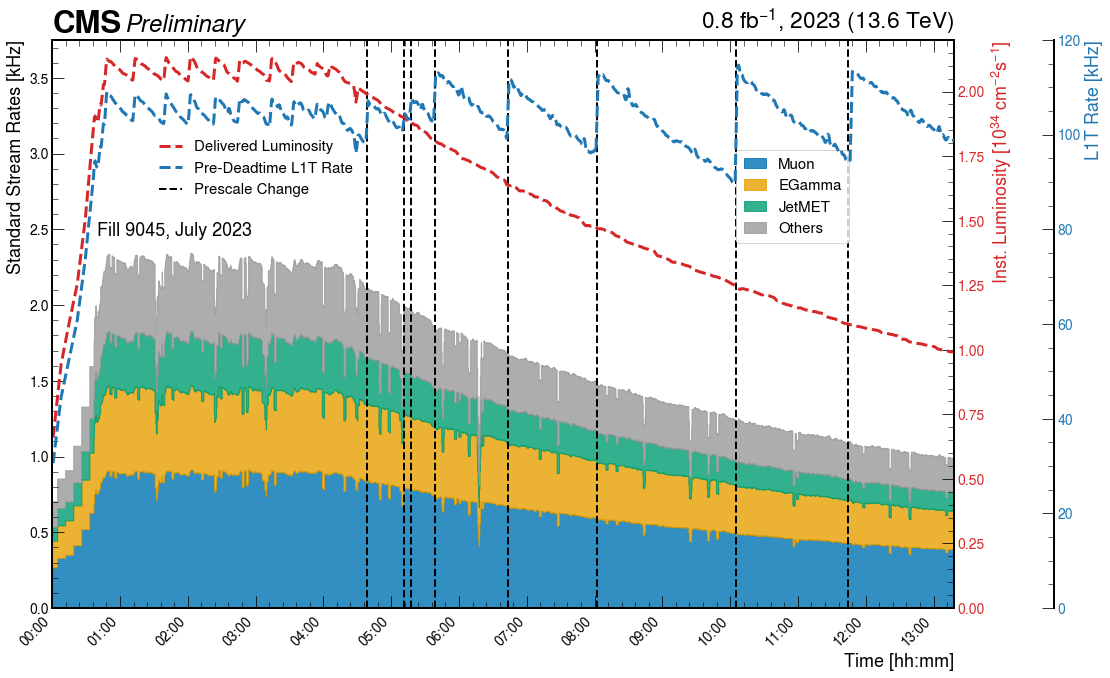

In [3]:
#!/usr/bin/env python3
import json
import numpy as np
import matplotlib.pyplot as plt
import mplhep as hep
from datetime import datetime
from matplotlib.ticker import MultipleLocator, FuncFormatter

# -----------------------------------------------------------------------------
# Configuration
# -----------------------------------------------------------------------------
JSON_PATH = "fill_9045.json"
RUNS_TO_PROCESS = {
    "370321": lambda ls: ls >= 49,
    "370332": lambda ls: ls >= 1,
}
SMOOTH_WINDOW = 5
OUTPUT_PDF = "fill9045_physics_rates_grouped.pdf"
OUTPUT_JPG = "fill9045_physics_rates_grouped.jpg"
OUTPUT_PNG = "fill9045_physics_rates_grouped.png"
YEAR = 2023
LUMI_LABEL = 0.8
CMS_ENERGY = 13.6

PRESCALE_LSES = [680, 763, 779, 834, 1001, 1204, 1521, 1775]
IGNORE_LSES = []

# -----------------------------------------------------------------------------
# Helpers
# -----------------------------------------------------------------------------
def moving_average(data, window_size=SMOOTH_WINDOW):
    arr = np.array(data, dtype=float)
    if len(arr) < window_size:
        return np.array([])
    csum = np.cumsum(np.insert(arr, 0, 0.0))
    return (csum[window_size:] - csum[:-window_size]) / float(window_size)

def hhmm_fmt(x, pos=None):
    h = int(x)
    m = int(round((x - h) * 60))
    return f"{h:02d}:{m:02d}"

# -----------------------------------------------------------------------------
# Load JSON and merge runs
# -----------------------------------------------------------------------------
with open(JSON_PATH) as fp:
    all_data = json.load(fp)

corrected_run_data = {}
ls_offset = 0

for run, ls_filter in RUNS_TO_PROCESS.items():
    run_data = all_data.get(run, {})
    if not run_data:
        continue

    all_ls = [e["LS"] for entries in run_data.values() for e in entries if ls_filter(e["LS"])]
    if not all_ls:
        continue

    last_ls = max(all_ls)
    for stream, entries in run_data.items():
        corrected_run_data.setdefault(stream, [])
        for e in entries:
            if not ls_filter(e["LS"]):
                continue
            e = e.copy()
            e["LS"] += ls_offset
            corrected_run_data[stream].append(e)

    ls_offset += last_ls

run_data = corrected_run_data

# -----------------------------------------------------------------------------
# Find t0
# -----------------------------------------------------------------------------
all_times = [
    datetime.strptime(e["start_time"], "%Y-%m-%dT%H:%M:%SZ")
    for entries in run_data.values() for e in entries
    if e["LS"] > 0 and e["LS"] not in IGNORE_LSES
]
if not all_times:
    raise RuntimeError("No good LS found!")
t0 = min(all_times)

# -----------------------------------------------------------------------------
# Aggregate streams
# -----------------------------------------------------------------------------
rates_by_stream = {}
deliv_lumi = {}
l1rate_raw = {}
ls_time = {}
pre_deadtime_l1 = {}

for stream, entries in run_data.items():
    if not stream.startswith("Physics"):
        continue

    rates_by_stream.setdefault(stream, {})
    for e in entries:
        ls = e["LS"]
        if ls <= 0 or ls in IGNORE_LSES:
            continue

        if ls not in ls_time:
            ts = datetime.strptime(e["start_time"], "%Y-%m-%dT%H:%M:%SZ")
            ls_time[ls] = ts
            deliv_lumi[ls] = e["delivered_lumi_per_lumisection"]

        rate = e.get("rate", 0.0) / 1000.0  # convert Hz to kHz
        rates_by_stream[stream][ls] = rate

        if ls not in l1rate_raw and "hlt_rate_Status_OnGPU" in e:
            l1rate_raw[ls] = e["hlt_rate_Status_OnGPU"] / 1000.0

        if "deadtime" in e and ls in l1rate_raw:
            dt = e["deadtime"]
            pre_deadtime_l1[ls] = l1rate_raw[ls] / (1 - dt) if dt < 1 else l1rate_raw[ls]

# -----------------------------------------------------------------------------
# Build sorted arrays & smooth
# -----------------------------------------------------------------------------
ls_sorted = sorted(ls_time)
time_arr = [(ls_time[ls] - t0).total_seconds()/3600.0 for ls in ls_sorted]

streams = sorted(rates_by_stream)
rates = {s: [rates_by_stream[s].get(ls, 0.0) for ls in ls_sorted] for s in streams}
lumi = [deliv_lumi[ls] for ls in ls_sorted]
l1r = [pre_deadtime_l1.get(ls, 0.0) for ls in ls_sorted]

time_sm = moving_average(time_arr)
rates_sm = {s: moving_average(rates[s]) for s in streams}
lumi_sm = moving_average(lumi)
l1_sm = moving_average(l1r)

L = min(len(time_sm), len(lumi_sm), len(l1_sm), *(len(rates_sm[s]) for s in streams))
time_sm = time_sm[:L]
lumi_sm = lumi_sm[:L]
l1_sm = l1_sm[:L]
for s in streams:
    rates_sm[s] = rates_sm[s][:L]

# -----------------------------------------------------------------------------
# Group streams
# -----------------------------------------------------------------------------
groups = {
    'Others': [s for s in streams if not any(x in s for x in ('Muon', 'EGamma', 'JetMET'))],
    'Muon':   [s for s in streams if 'Muon' in s],
    'EGamma': [s for s in streams if 'EGamma' in s],
    'JetMET': [s for s in streams if 'JetMET' in s],
}

colors = {
    'Muon':   '#0072B2',
    'EGamma': '#E69F00',
    'JetMET': '#009E73',
    'Others': '#999999',
}

# -----------------------------------------------------------------------------
# Plot
# -----------------------------------------------------------------------------
plt.style.use(hep.style.CMS)
fig, ax1 = plt.subplots(figsize=(16, 10))
fig.subplots_adjust(left=0.30, right=0.78, top=0.88)

cumul, handles, labels = np.zeros(L), [], []

for name in ['Muon', 'EGamma', 'JetMET', 'Others']:
    ysum = sum(rates_sm[s] for s in groups[name])
    h = ax1.fill_between(time_sm, cumul, cumul + ysum,
                         step="mid", alpha=0.8, color=colors[name], label=name)
    handles.append(h)
    labels.append(name)
    cumul += ysum

# Prescale transitions
prescale_handle = None
for ls in PRESCALE_LSES:
    if ls in ls_sorted:
        idx = ls_sorted.index(ls)
        j = max(0, idx - (SMOOTH_WINDOW//2))
        x = time_sm[j]
        if prescale_handle is None:
            prescale_handle = ax1.axvline(x, color="black", linestyle="--", linewidth=2, label="Prescale Change")
        else:
            ax1.axvline(x, color="black", linestyle="--", linewidth=2)

# Axes formatting
ax1.set_xlabel("Time [hh:mm]", fontsize=18)
ax1.set_ylabel("Standard Stream Rates [kHz]", fontsize=18)
ax1.set_xlim(0, time_sm[-1]*0.99)
ax1.set_ylim(0, cumul.max()*1.6)
ax1.tick_params(labelsize=14)
ax1.xaxis.set_major_locator(MultipleLocator(1))
ax1.xaxis.set_major_formatter(FuncFormatter(hhmm_fmt))
plt.setp(ax1.get_xticklabels(), rotation=45, ha="right")

hep.cms.label(data=True, year=YEAR, lumi=LUMI_LABEL,
              loc=0, ax=ax1, com=CMS_ENERGY, label="Preliminary", fontsize=24)

ax1.text(0.05, 0.68, "Fill 9045, July 2023", transform=ax1.transAxes, fontsize=18, verticalalignment="top")

# Delivered lumi
ax2 = ax1.twinx()
lum_handle, = ax2.plot(time_sm, lumi_sm*100/23.31, color="tab:red", linestyle="--", linewidth=3, label="Delivered Luminosity")
ax2.set_ylabel("Inst. Luminosity [$10^{34}$ cm$^{-2}$s$^{-1}$]", color="tab:red", fontsize=18)
ax2.tick_params(labelcolor="tab:red", labelsize=14)
ax2.set_ylim(0, 2.2)

# Pre-deadtime L1
ax3 = ax1.twinx()
ax3.spines["right"].set_position(("outward",100))
l1_handle, = ax3.plot(time_sm, l1_sm, color="tab:blue", linestyle="--", linewidth=3, label="Pre-Deadtime L1T Rate")
ax3.set_ylabel("L1T Rate [kHz]", color="tab:blue", fontsize=18)
ax3.tick_params(labelcolor="tab:blue", labelsize=14)
ax3.set_ylim(0,120)

# Legends
leg1 = ax1.legend(handles, labels, loc="upper left", bbox_to_anchor=(0.75, 0.82), frameon=True, framealpha=0.8, fontsize=15)
ax1.add_artist(leg1)

extra_labels = [lum_handle, l1_handle]
extra_names = ["Delivered Luminosity", "Pre-Deadtime L1T Rate"]
if prescale_handle:
    extra_labels.append(prescale_handle)
    extra_names.append("Prescale Change")

leg2 = ax1.legend(extra_labels, extra_names, loc="upper right", bbox_to_anchor=(0.35, 0.85), fontsize=15)

plt.tight_layout()
fig.savefig(OUTPUT_PDF, dpi=1200)
fig.savefig(OUTPUT_JPG, dpi=1200)
fig.savefig(OUTPUT_PNG, dpi=1200)
print(f"Saved {OUTPUT_PDF}, {OUTPUT_JPG}")


Saved fill9045_parking_rates.pdf, fill9045_parking_rates.jpg


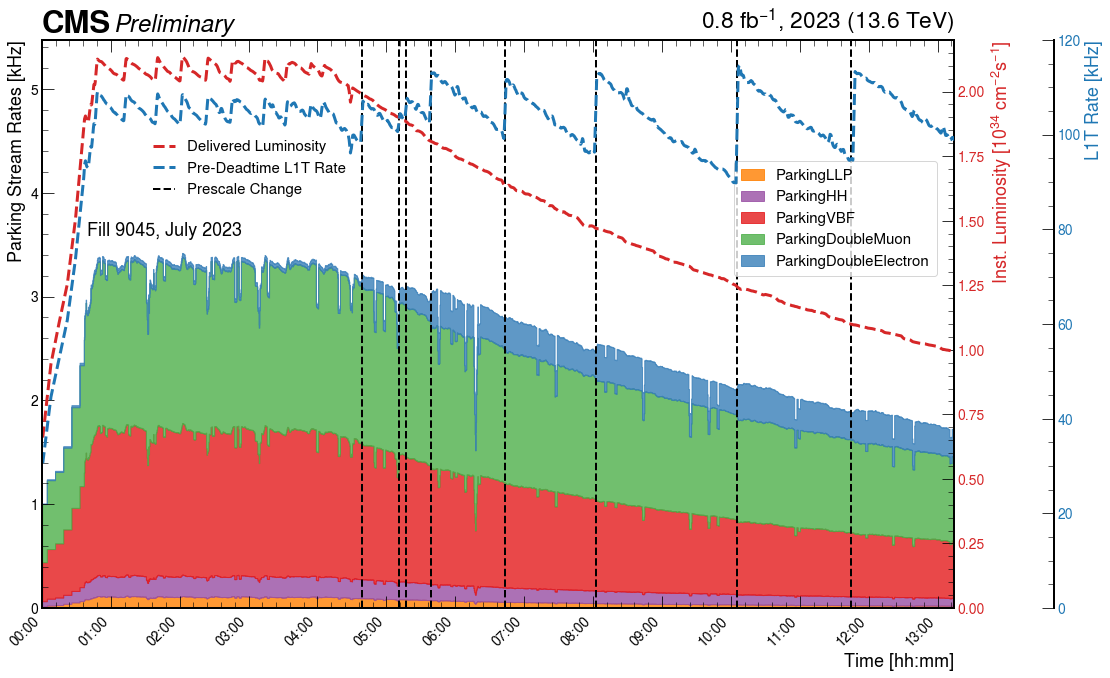

In [4]:
import json
import numpy as np
import matplotlib.pyplot as plt
import mplhep as hep
from datetime import datetime
from matplotlib.ticker import MultipleLocator, FuncFormatter

# -----------------------------------------------------------------------------
# Configuration
# -----------------------------------------------------------------------------
JSON_PATH = "fill_9045.json"
RUNS_TO_PROCESS = {
    "370321": lambda ls: ls >= 49,
    "370332": lambda ls: ls >= 1,
}
SMOOTH_WINDOW = 5
OUTPUT_PDF = "fill9045_parking_rates.pdf"
OUTPUT_JPG = "fill9045_parking_rates.jpg"
OUTPUT_PNG = "fill9045_parking_rates.png"
YEAR = 2023
LUMI_LABEL = 0.8
CMS_ENERGY = 13.6

PRESCALE_LSES = [680, 763, 779, 834, 1001, 1204, 1521, 1775]
IGNORE_LSES = []

# -----------------------------------------------------------------------------
# Helpers
# -----------------------------------------------------------------------------
def moving_average(data, window_size=SMOOTH_WINDOW):
    arr = np.array(data, dtype=float)
    if len(arr) < window_size:
        return np.array([])
    csum = np.cumsum(np.insert(arr, 0, 0.0))
    return (csum[window_size:] - csum[:-window_size]) / float(window_size)

def canonical_name(name):
    for base in ["ParkingDoubleMuon", "ParkingDoubleElectron", "ParkingVBF", "ParkingHH", "ParkingLLP"]:
        if name.startswith(base):
            return base
    return None

def hhmm_fmt(x, pos=None):
    h = int(x)
    m = int(round((x - h)*60))
    return f"{h:02d}:{m:02d}"

# -----------------------------------------------------------------------------
# Load JSON and merge runs
# -----------------------------------------------------------------------------
with open(JSON_PATH) as fp:
    all_data = json.load(fp)

corrected_run_data = {}
ls_offset = 0

for run, ls_filter in RUNS_TO_PROCESS.items():
    run_data = all_data.get(run, {})
    if not run_data:
        continue

    all_ls = [e["LS"] for entries in run_data.values() for e in entries if ls_filter(e["LS"])]
    if not all_ls:
        continue

    last_ls = max(all_ls)
    for stream, entries in run_data.items():
        corrected_run_data.setdefault(stream, [])
        for e in entries:
            if not ls_filter(e["LS"]):
                continue
            e = e.copy()
            e["LS"] += ls_offset
            corrected_run_data[stream].append(e)

    ls_offset += last_ls

run_data = corrected_run_data

# -----------------------------------------------------------------------------
# Find t0
# -----------------------------------------------------------------------------
all_times = [
    datetime.strptime(e["start_time"], "%Y-%m-%dT%H:%M:%SZ")
    for entries in run_data.values() for e in entries
    if e["LS"] > 0 and e["LS"] not in IGNORE_LSES
]
if not all_times:
    raise RuntimeError("No good LS found!")
t0 = min(all_times)

# -----------------------------------------------------------------------------
# Aggregate streams
# -----------------------------------------------------------------------------
summed_rates = {}
deliv_lumi = {}
l1rate_raw = {}
ls_time = {}
pre_deadtime_l1 = {}

for stream, entries in run_data.items():
    if not stream.startswith("Parking"):
        continue

    base = canonical_name(stream)
    if not base:
        continue

    for e in entries:
        ls = e["LS"]
        if ls <= 0 or ls in IGNORE_LSES:
            continue

        if ls not in ls_time:
            ts = datetime.strptime(e["start_time"], "%Y-%m-%dT%H:%M:%SZ")
            ls_time[ls] = ts
            deliv_lumi[ls] = e["delivered_lumi_per_lumisection"]

        summed_rates.setdefault(base, {})
        summed_rates[base][ls] = summed_rates[base].get(ls, 0.0) + e["rate"] / 1000.0

        if ls not in l1rate_raw and "hlt_rate_Status_OnGPU" in e:
            l1rate_raw[ls] = e["hlt_rate_Status_OnGPU"] / 1000.0

        if "deadtime" in e and ls in l1rate_raw:
            dt = e["deadtime"]
            pre_deadtime_l1[ls] = l1rate_raw[ls] / (1 - dt) if dt < 1 else l1rate_raw[ls]

# -----------------------------------------------------------------------------
# Build sorted arrays
# -----------------------------------------------------------------------------
ls_sorted = sorted(ls_time)
time_arr = [(ls_time[ls]-t0).total_seconds()/3600.0 for ls in ls_sorted]

ordered_streams = [ "ParkingLLP","ParkingHH","ParkingVBF",  "ParkingDoubleMuon","ParkingDoubleElectron" ]

rates = {s: [summed_rates.get(s, {}).get(ls, 0.0) for ls in ls_sorted] for s in ordered_streams}
lumi   = [deliv_lumi[ls] for ls in ls_sorted]
l1r    = [pre_deadtime_l1.get(ls, 0.0) for ls in ls_sorted]

time_sm  = moving_average(time_arr)
rates_sm = {s: moving_average(rates[s]) for s in ordered_streams}
lumi_sm  = moving_average(lumi)
l1_sm    = moving_average(l1r)

L = min(len(time_sm), len(lumi_sm), len(l1_sm), *(len(rates_sm[s]) for s in ordered_streams))
time_sm = time_sm[:L]
lumi_sm = lumi_sm[:L]
l1_sm   = l1_sm[:L]
for s in ordered_streams:
    rates_sm[s] = rates_sm[s][:L]

# -----------------------------------------------------------------------------
# Colors
# -----------------------------------------------------------------------------
colors = {
    "ParkingDoubleElectron": "#377eb8", # blue
    "ParkingDoubleMuon": "#4daf4a",     # green
    "ParkingVBF": "#e41a1c",            # red
    "ParkingHH": "#984ea3",             # purple
    "ParkingLLP": "#ff7f00",             # orange
}

# -----------------------------------------------------------------------------
# Plot
# -----------------------------------------------------------------------------
plt.style.use(hep.style.CMS)
fig, ax1 = plt.subplots(figsize=(16,10))
fig.subplots_adjust(left=0.30, right=0.78, top=0.88)

cumul, handles, labels = np.zeros(L), [], []

for s in ordered_streams:
    h = ax1.fill_between(time_sm, cumul, cumul + rates_sm[s], step="mid", alpha=0.8, color=colors[s], label=s)
    handles.append(h)
    labels.append(s)
    cumul += rates_sm[s]

# Prescale transitions
prescale_handle = None
for ls in PRESCALE_LSES:
    if ls in ls_sorted:
        idx = ls_sorted.index(ls)
        j = max(0, idx - (SMOOTH_WINDOW//2))
        x = time_sm[j]
        if prescale_handle is None:
            prescale_handle = ax1.axvline(x, color="black", linestyle="--", linewidth=2, label="Prescale Change")
        else:
            ax1.axvline(x, color="black", linestyle="--", linewidth=2)

# Axes formatting
ax1.set_xlabel("Time [hh:mm]", fontsize=18)
ax1.set_ylabel("Parking Stream Rates [kHz]", fontsize=18)
ax1.set_xlim(0, time_sm[-1]*0.99)
ax1.set_ylim(0, cumul.max()*1.6)
ax1.tick_params(labelsize=14)
ax1.xaxis.set_major_locator(MultipleLocator(1))
ax1.xaxis.set_major_formatter(FuncFormatter(hhmm_fmt))
plt.setp(ax1.get_xticklabels(), rotation=45, ha="right")

hep.cms.label(data=True, year=YEAR, lumi=LUMI_LABEL,
              loc=0, ax=ax1, com=CMS_ENERGY, label="Preliminary", fontsize=24)

ax1.text(0.05, 0.68, "Fill 9045, July 2023", transform=ax1.transAxes, fontsize=18, verticalalignment="top")

# Delivered lumi
ax2 = ax1.twinx()
lum_handle, = ax2.plot(time_sm, lumi_sm*100/23.31, color="tab:red", linestyle="--", linewidth=3, label="Delivered Luminosity")
ax2.set_ylabel("Inst. Luminosity [$10^{34}$ cm$^{-2}$s$^{-1}$]", color="tab:red", fontsize=18)
ax2.tick_params(labelcolor="tab:red", labelsize=14)
ax2.set_ylim(0,2.2)

# Pre-deadtime L1
ax3 = ax1.twinx()
ax3.spines["right"].set_position(("outward",100))
l1_handle, = ax3.plot(time_sm, l1_sm, color="tab:blue", linestyle="--", linewidth=3, label="Pre-Deadtime L1T Rate")
ax3.set_ylabel("L1T Rate [kHz]", color="tab:blue", fontsize=18)
ax3.tick_params(labelcolor="tab:blue", labelsize=14)
ax3.set_ylim(0,120)

# Legends
leg1 = ax1.legend(handles, labels, loc="upper left", bbox_to_anchor=(0.75, 0.80), frameon=True, framealpha=0.8, fontsize=15)
ax1.add_artist(leg1)

extra_labels = [lum_handle, l1_handle]
extra_names = ["Delivered Luminosity", "Pre-Deadtime L1T Rate"]
if prescale_handle:
    extra_labels.append(prescale_handle)
    extra_names.append("Prescale Change")

leg2 = ax1.legend(extra_labels, extra_names, loc="upper right", bbox_to_anchor=(0.35, 0.85), fontsize=15)

plt.tight_layout()
fig.savefig(OUTPUT_PDF, dpi=1200)
fig.savefig(OUTPUT_JPG, dpi=1200)
fig.savefig(OUTPUT_PNG, dpi=1200)
print(f"Saved {OUTPUT_PDF}, {OUTPUT_JPG}")
